In [67]:
%pylab inline
import gdal
import gdalio
from sklearn.cross_decomposition import CCA
import scipy as sc
from scipy import stats
from scipy.spatial.distance import cosine

Populating the interactive namespace from numpy and matplotlib


In [12]:
# load test dataset

import csv

with open("test_files_aligned.csv",'r') as f:
    reader = csv.reader(f.readlines())
    next(reader) # skip header
    test_pairs = [i for i in reader]
    print(len(test_pairs),'pairs loaded')

59 pairs loaded


In [24]:
f1, f2 = test_pairs[6]
img1, img2 = gdalio.readAsArray(gdal.Open(f1)), gdalio.readAsArray(gdal.Open(f2))

In [52]:
# assemble images for display

def fix_image(img,p=1):
    pmin = np.percentile(img,p)
    pmax = np.percentile(img,100-p)
    
    img = (img-pmin)/(pmax-pmin)
    img[img<0] = 0
    img[img>1] = 1
    return img

cca = CCA(n_components=3)
cca.fit(img1.reshape((-1,12)),img2.reshape((-1,12)))
img1_display, img2_display = cca.transform(img1.reshape((-1,12)),img2.reshape((-1,12)))
img1_display = fix_image( img1_display.reshape( (img1.shape[0],img1.shape[1],3) ) )
img2_display = fix_image( img2_display.reshape( (img2.shape[0],img2.shape[1],3) ) )

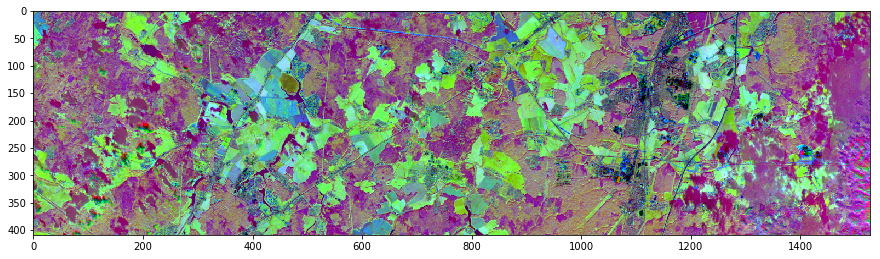

In [56]:
imshow(img1_display)

In [68]:
# First iteartion

correlation_change = []
iteration_num = 0
P = np.ones(X.shape[0])
old_x_weights = None
old_y_weights = None

distances_cosine_max = []
distances_cosine_mean = []
distances_euqlidian_max = []
distances_euqlidian_mean = []

# First iteration

width = img1.shape[1]
height = img1.shape[0]
X = img1.reshape(-1,12)
Y = img2.reshape(-1,12)
X = X-X.mean(axis=0)
Y = Y-Y.mean(axis=0)
cca = CCA(n_components=10,scale=False)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

M = np.zeros(X_c.shape)
for i in np.arange(0,X_c.shape[1]):
    M[:,i] = X_c[:,X_c.shape[1]-i-1]-Y_c[:,X_c.shape[1]-i-1]
    
#M = X_c - Y_c

sigma = np.array( [np.std(M[:,i]) for i in range(M.shape[1])] )
Z = ((M/sigma)**2).sum(axis=1)
P = 1-sc.stats.chi2.cdf( Z, 10, 0 )

In [95]:
# second iteration
X_weighted = X*np.sqrt(P[:,np.newaxis])
Y_weighted = Y*np.sqrt(P[:,np.newaxis])
cca = CCA(n_components=10,scale=False)
cca.fit(X_weighted, Y_weighted)
X_c, Y_c = cca.transform(X, Y)

M = np.zeros(X_c.shape)

for i in np.arange(0,X_c.shape[1]):
    M[:,i] = X_c[:,X_c.shape[1]-i-1]-Y_c[:,X_c.shape[1]-i-1]
sigma = np.array( [np.std(M[:,i]) for i in range(M.shape[1])] )
Z = ((M/sigma)**2).sum(axis=1)
P = 1-sc.stats.chi2.cdf( Z, 10, 0 )

iteration_num+=1
print('Iteration number: {}'.format(iteration_num))
cor_vec = []
for i in range(X_weighted.shape[1]):
    cor_vec.append( np.corrcoef(X_weighted[:,i],Y_weighted[:,i])[0,1] )
correlation_change.append(cor_vec)
print('correlations:')
print(cor_vec)

if old_x_weights is not None:
    dist_cos_x = np.array( [ cosine(old_x_weights[i],cca.x_weights_[i]) for i in range(cca.x_weights_.shape[0]) ] )
    dist_cos_y = np.array( [ cosine(old_y_weights[i],cca.y_weights_[i]) for i in range(cca.y_weights_.shape[0]) ] )
    dist_cos = np.concatenate((dist_cos_x,dist_cos_y))
    
    dist_euq_x = np.array( [ ((old_x_weights[i]-cca.x_weights_[i])**2).sum() for i in range(cca.x_weights_.shape[0]) ] )
    dist_euq_y = np.array( [ ((old_y_weights[i]-cca.y_weights_[i])**2).sum() for i in range(cca.x_weights_.shape[0]) ] )
    dist_euq = np.concatenate((dist_euq_x,dist_euq_y))
    
    distances_cosine_max.append( dist_cos.min() )
    distances_cosine_mean.append( np.median( dist_cos ) )
    distances_euqlidian_max.append( np.median( np.concatenate( ( ((old_x_weights[i]-cca.x_weights_[i])**2), 
                                              ((old_y_weights[i]-cca.y_weights_[i])**2) ) ) ) )
    distances_euqlidian_mean.append( np.median( dist_euq ) )
    
old_x_weights = cca.x_weights_
old_y_weights = cca.y_weights_

Iteration number: 16
correlations:
[0.36890947150278297, 0.43837288825434456, 0.59445189417712208, 0.53215048459670944, 0.58549996103437196, 0.65293675898852099, 0.61935231334092233, 0.56691829523436066, 0.021858140256519533, 0.33199443681968521, 0.23232577745084895, -0.041318465198884866]


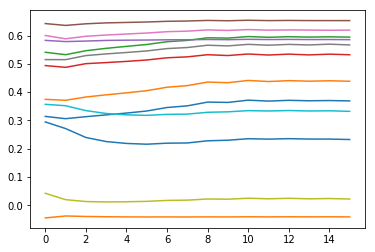

In [96]:
plot( correlation_change );

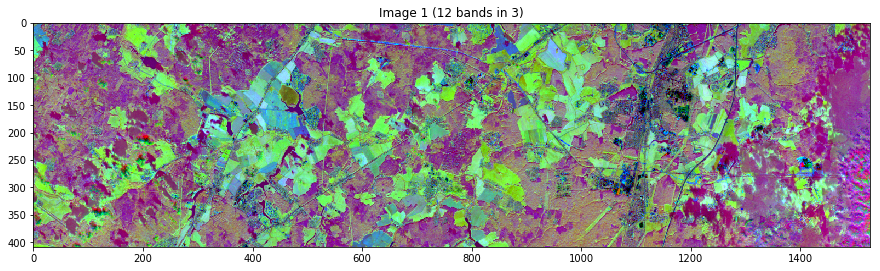

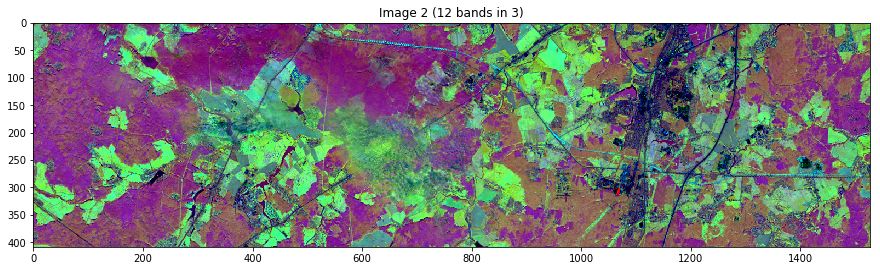

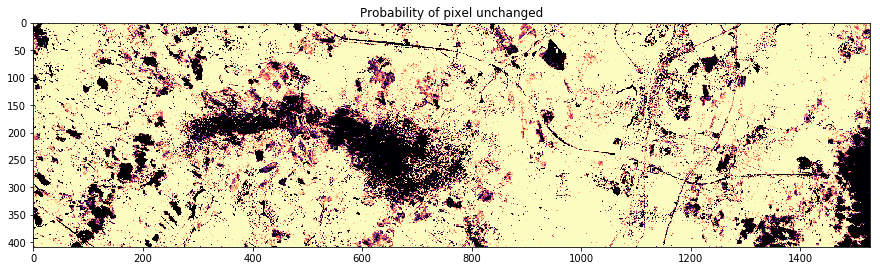

In [109]:
figsize(15,15)
title("Image 1 (12 bands in 3)")
imshow(img1_display)
show();
title("Image 2 (12 bands in 3)")
imshow(img2_display);
show();
title("Probability of pixel unchanged")
imshow( P.reshape(height,width), cmap='magma',vmin=0.5,vmax=0.95 )
show()